# Model Comparison: Cross-Domain Performance Analysis

This notebook evaluates different model training strategies for fiber orientation prediction:

1. Bio-Trained Models:
   - Raw biological data
   - Balanced biological data
   - Augmented biological data

2. Diffusion-Trained Models:
   - Raw diffusion data
   - Balanced diffusion data

3. Combined-Trained Models:
   - Raw combined data
   - Balanced combined data
   - Augmented combined data

Each approach is evaluated against a held-out biological test set to assess generalization performance.

In [37]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# Add src directory to Python path for imports
sys.path.append(os.path.abspath('../../src'))

# Import from our package
from fiber_predictor.svr_hog.data_processing import HogDataset, balance_dataset
from fiber_predictor.svr_hog.models import FiberPredictor

IMAGE_DIR = '../../images'
MODEL_DIR = '../../models'

## 1. Data Loading and Initial Processing

In [38]:
# HOG parameters
grid_quotient = np.arange(1, 4)
orientations = 10

# Dataset paths
bio_file_dir = os.path.join(IMAGE_DIR, "bio/")
bio_csv_dir = os.path.join(IMAGE_DIR, "bio/labels.csv")
diff_file_dir = os.path.join(IMAGE_DIR, "diffusion/")
diff_csv_dir = os.path.join(IMAGE_DIR, "diffusion/labels.csv")

# Define bins for balancing (every 20 degrees)
ANGLE_BINS = np.arange(0, 181, 20)

def load_dataset(file_dir, csv_dir, augment=False, balance=False):
    dataset = HogDataset(
        labels_path=csv_dir,
        file_dir=file_dir,
        grid_quotient=grid_quotient,
        orientations=orientations,
        augment_whole_dataset=augment
    )
    
    if balance:
        balance_dataset(dataset, ANGLE_BINS)
    
    feature_matrix = []
    labels = []
    for idx in range(len(dataset)):
        _, features_tensor, angle = dataset[idx]
        feature_matrix.append(features_tensor.numpy())
        labels.append(angle)
    
    feature_matrix = np.array(feature_matrix)
    labels = np.array(labels)
    
    return {
        'features': feature_matrix,
        'labels': labels,
        'n_samples': len(labels)
    }

# Load and split biological dataset for test evaluation
bio_full = load_dataset(bio_file_dir, bio_csv_dir)
train_features, test_features, train_labels, test_labels = train_test_split(
    bio_full['features'], bio_full['labels'],
    test_size=0.2, random_state=42
)

# Load all training datasets
print("Loading training datasets...")

# Bio datasets
bio_raw = {
    'features': train_features,
    'labels': train_labels,
    'n_samples': len(train_labels)
}
bio_balanced = load_dataset(bio_file_dir, bio_csv_dir, balance=True)
bio_aug = load_dataset(bio_file_dir, bio_csv_dir, augment=True)
bio_aug_balanced = load_dataset(bio_file_dir, bio_csv_dir, augment=True, balance=True)

# Diffusion datasets
diff_raw = load_dataset(diff_file_dir, diff_csv_dir)
diff_balanced = load_dataset(diff_file_dir, diff_csv_dir, balance=True)

# Combined datasets
combined_raw = {
    'features': np.vstack([bio_raw['features'], diff_raw['features']]),
    'labels': np.concatenate([bio_raw['labels'], diff_raw['labels']]),
    'n_samples': bio_raw['n_samples'] + diff_raw['n_samples']
}
combined_balanced = {
    'features': np.vstack([bio_balanced['features'], diff_balanced['features']]),
    'labels': np.concatenate([bio_balanced['labels'], diff_balanced['labels']]),
    'n_samples': bio_balanced['n_samples'] + diff_balanced['n_samples']
}
combined_aug = {
    'features': np.vstack([bio_aug['features'], diff_raw['features']]),
    'labels': np.concatenate([bio_aug['labels'], diff_raw['labels']]),
    'n_samples': bio_aug['n_samples'] + diff_raw['n_samples']
}

print("\nDataset Sizes:")
print(f"Bio Test Set: {len(test_labels)} samples")
print(f"\nBio Training Sets:")
print(f"Raw: {bio_raw['n_samples']} samples")
print(f"Balanced: {bio_balanced['n_samples']} samples")
print(f"Augmented: {bio_aug['n_samples']} samples")
print(f"Aug+Balanced: {bio_aug_balanced['n_samples']} samples")
print(f"\nDiffusion Training Sets:")
print(f"Raw: {diff_raw['n_samples']} samples")
print(f"Balanced: {diff_balanced['n_samples']} samples")
print(f"\nCombined Training Sets:")
print(f"Raw: {combined_raw['n_samples']} samples")
print(f"Balanced: {combined_balanced['n_samples']} samples")
print(f"Augmented: {combined_aug['n_samples']} samples")

# Tracking DataFrame
tracking_data = []

Loading training datasets...

Dataset Sizes:
Bio Test Set: 135 samples

Bio Training Sets:
Raw: 538 samples
Balanced: 108 samples
Augmented: 4711 samples
Aug+Balanced: 1008 samples

Diffusion Training Sets:
Raw: 609 samples
Balanced: 306 samples

Combined Training Sets:
Raw: 1147 samples
Balanced: 414 samples
Augmented: 5320 samples


## 2. Model Training and Evaluation Function

In [39]:
def train_evaluate_model(X_train, y_train, model_name=None):
    """Train model and evaluate on test set"""
    # Train model
    model = FiberPredictor(
        scaler_type="Standard",
        pca_params={"n_components": 0.95},
        regressor_type="SVR",
        regressor_params={"kernel": "rbf", "C": 100, "gamma": 0.01}
    )
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    test_pred = model.predict(test_features)
    test_mae = mean_absolute_error(test_labels, test_pred)
    test_r2 = r2_score(test_labels, test_pred)
    
    print(f"Test Set Performance:")
    print(f"MAE: {test_mae:.2f}°")
    print(f"R²: {test_r2:.3f}")
    
    # Track results
    result = {
        'model_name': model_name,
        'training_data': model_name.split('_')[0],
        'approach': '_'.join(model_name.split('_')[1:]),
        'n_train': len(X_train),
        'test_mae': test_mae,
        'test_r2': test_r2
    }
    
    tracking_data.append(result)
    
    # Save model if name provided
    if model_name:
        with open(os.path.join(MODEL_DIR, f'svr_hog/{model_name}.pkl'), 'wb') as f:
            pickle.dump(model, f)
    
    return model, test_pred

## 3. Training and Evaluation Scenarios

In [40]:
# Bio-trained models
print("Training bio-based models...")
bio_raw_model, bio_raw_pred = train_evaluate_model(
    bio_raw['features'],
    bio_raw['labels'],
    model_name='bio_raw'
)

print("\nTraining balanced bio model...")
bio_balanced_model, bio_balanced_pred = train_evaluate_model(
    bio_balanced['features'],
    bio_balanced['labels'],
    model_name='bio_balanced'
)

print("\nTraining augmented bio model...")
bio_aug_model, bio_aug_pred = train_evaluate_model(
    bio_aug['features'],
    bio_aug['labels'],
    model_name='bio_augmented'
)

# Diffusion-trained models
print("\nTraining diffusion-based models...")
diff_raw_model, diff_raw_pred = train_evaluate_model(
    diff_raw['features'],
    diff_raw['labels'],
    model_name='diff_raw'
)

print("\nTraining balanced diffusion model...")
diff_balanced_model, diff_balanced_pred = train_evaluate_model(
    diff_balanced['features'],
    diff_balanced['labels'],
    model_name='diff_balanced'
)

# Combined-trained models
print("\nTraining combined models...")
combined_raw_model, combined_raw_pred = train_evaluate_model(
    combined_raw['features'],
    combined_raw['labels'],
    model_name='combined_raw'
)

print("\nTraining balanced combined model...")
combined_balanced_model, combined_balanced_pred = train_evaluate_model(
    combined_balanced['features'],
    combined_balanced['labels'],
    model_name='combined_balanced'
)

print("\nTraining augmented combined model...")
combined_aug_model, combined_aug_pred = train_evaluate_model(
    combined_aug['features'],
    combined_aug['labels'],
    model_name='combined_augmented'
)

Training bio-based models...
Test Set Performance:
MAE: 15.64°
R²: 0.694

Training balanced bio model...
Test Set Performance:
MAE: 15.23°
R²: 0.685

Training augmented bio model...
Test Set Performance:
MAE: 11.90°
R²: 0.800

Training diffusion-based models...
Test Set Performance:
MAE: 20.33°
R²: 0.662

Training balanced diffusion model...
Test Set Performance:
MAE: 19.36°
R²: 0.684

Training combined models...
Test Set Performance:
MAE: 15.08°
R²: 0.701

Training balanced combined model...
Test Set Performance:
MAE: 15.50°
R²: 0.683

Training augmented combined model...
Test Set Performance:
MAE: 12.33°
R²: 0.788


## 4. Results Summary

Model Performance Summary (sorted by test MAE):


,model_name,training_data,approach,n_train,test_mae,test_r2
2,bio_augmented,bio,augmented,4711,11.899607,0.800229
7,combined_augmented,combined,augmented,5320,12.329013,0.787711
5,combined_raw,combined,raw,1147,15.084163,0.701265
1,bio_balanced,bio,balanced,108,15.234273,0.684794
6,combined_balanced,combined,balanced,414,15.497878,0.683165
0,bio_raw,bio,raw,538,15.642265,0.694326
4,diff_balanced,diff,balanced,306,19.355225,0.683803
3,diff_raw,diff,raw,609,20.326173,0.661780


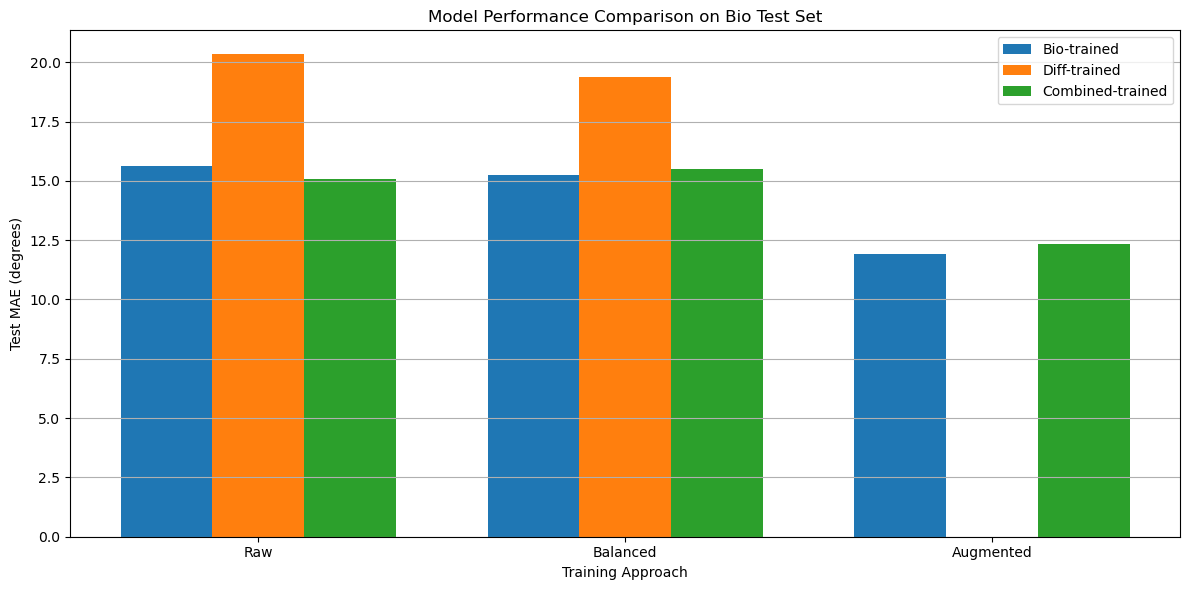

In [41]:
# Create summary DataFrame
summary_df = pd.DataFrame(tracking_data)

# Sort by test MAE to find best performing models
summary_df = summary_df.sort_values('test_mae')

# Display results
print("Model Performance Summary (sorted by test MAE):")
display(summary_df)

# Plot comparison by training data source and approach
plt.figure(figsize=(12, 6))

# Create positions for bars
x = np.arange(3)  # raw, balanced, augmented

# Plot bars for each training data source
for i, source in enumerate(['bio', 'diff', 'combined']):
    source_data = summary_df[summary_df['training_data'] == source]
    
    # Get MAE values aligned by approach
    raw = source_data[source_data['approach'] == 'raw']['test_mae'].values
    balanced = source_data[source_data['approach'] == 'balanced']['test_mae'].values
    augmented = source_data[source_data['approach'] == 'augmented']['test_mae'].values
    
    # Plot available approaches
    values = []
    if len(raw) > 0: values.append(raw[0])
    if len(balanced) > 0: values.append(balanced[0])
    if len(augmented) > 0: values.append(augmented[0])
    
    plt.bar(x[:len(values)] + i*0.25, values, 0.25, label=f'{source.capitalize()}-trained')

plt.xlabel('Training Approach')
plt.ylabel('Test MAE (degrees)')
plt.title('Model Performance Comparison on Bio Test Set')
plt.xticks(x + 0.25, ['Raw', 'Balanced', 'Augmented'])
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Save summary to CSV
summary_df.to_csv(os.path.join(MODEL_DIR, 'svr_hog/model_comparison_summary.csv'), index=False)

## 5. Error Analysis

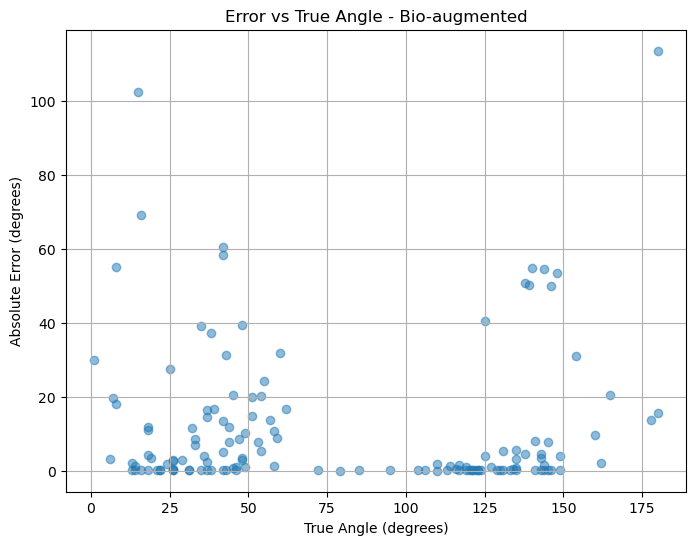

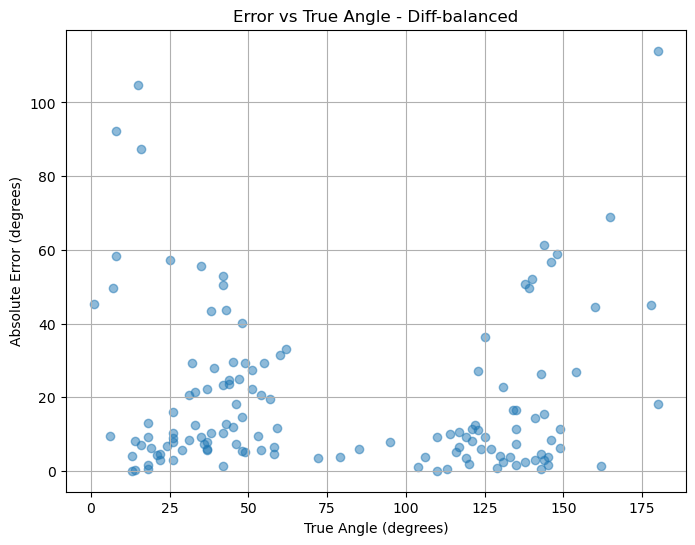

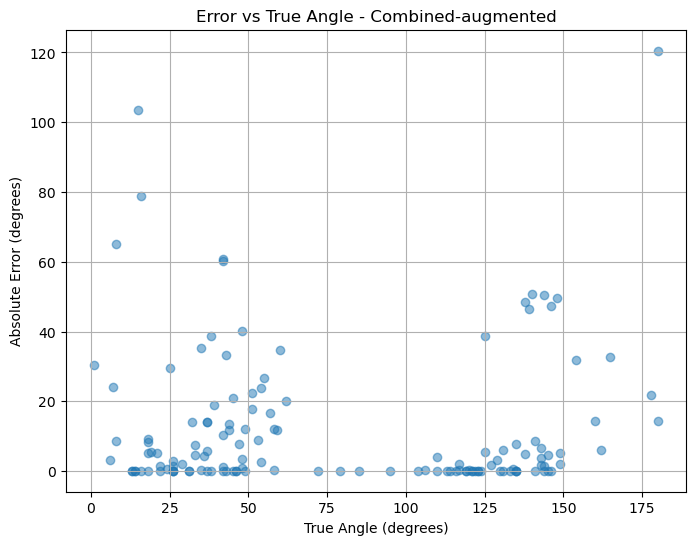

In [42]:
def plot_error_vs_angle(true_angles, predictions, model_name):
    errors = np.abs(predictions - true_angles)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(true_angles, errors, alpha=0.5)
    plt.xlabel('True Angle (degrees)')
    plt.ylabel('Absolute Error (degrees)')
    plt.title(f'Error vs True Angle - {model_name}')
    plt.grid(True)
    plt.show()

# Plot error distributions for best model from each training source
bio_models = summary_df[summary_df['training_data'] == 'bio'].iloc[0]
diff_models = summary_df[summary_df['training_data'] == 'diff'].iloc[0]
combined_models = summary_df[summary_df['training_data'] == 'combined'].iloc[0]

for model_info, pred in [
    (bio_models, bio_raw_pred if bio_models['approach'] == 'raw' else 
                bio_balanced_pred if bio_models['approach'] == 'balanced' else bio_aug_pred),
    (diff_models, diff_raw_pred if diff_models['approach'] == 'raw' else diff_balanced_pred),
    (combined_models, combined_raw_pred if combined_models['approach'] == 'raw' else
                     combined_balanced_pred if combined_models['approach'] == 'balanced' else combined_aug_pred)
]:
    plot_error_vs_angle(test_labels, pred, 
                        f"{model_info['training_data'].capitalize()}-{model_info['approach']}")
